<a href="https://colab.research.google.com/github/butaud/makemore/blob/main/building_makemore_part_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [3]:
# download the names.txt file from github
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2024-03-13 20:36:10--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.006s  

2024-03-13 20:36:11 (35.0 MB/s) - ‘names.txt’ saved [228145/228145]



In [4]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [5]:
len(words)

32033

In [6]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


### Define hyperparameters

In [7]:
BLOCK_SIZE = 3
EMBEDDING_DIMENSIONALITY = 10
INPUT_NEURON_COUNT = BLOCK_SIZE * EMBEDDING_DIMENSIONALITY
HIDDEN_LAYER_SIZE = 100

In [8]:
# build the dataset

def build_dataset(words):
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * BLOCK_SIZE
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


Layer classes

In [9]:
class Linear:
  def __init__(self, fan_in, fan_out, generator, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=generator) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out

  def parameters(self):
    return []


Initialize the model

In [13]:
# model params
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, EMBEDDING_DIMENSIONALITY), generator=g)

layers = [
    Linear(INPUT_NEURON_COUNT, HIDDEN_LAYER_SIZE, g), BatchNorm1d(HIDDEN_LAYER_SIZE), Tanh(),
    Linear( HIDDEN_LAYER_SIZE, HIDDEN_LAYER_SIZE, g), BatchNorm1d(HIDDEN_LAYER_SIZE), Tanh(),
    Linear( HIDDEN_LAYER_SIZE, vocab_size, g), BatchNorm1d(vocab_size),
]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True

16651


In [14]:
# learning characteristics
BATCH_SIZE = 32
TRAINING_PASSES = 200000
START_STEP_SIZE = 0.1
END_STEP_SIZE = 0.01

def calculate_learning_rate(current_pass, total_passes):
  #lr_decrease = (START_STEP_SIZE - END_STEP_SIZE) / (total_passes)
  #current_lr = START_STEP_SIZE - lr_decrease * current_pass
  current_lr = START_STEP_SIZE if current_pass < TRAINING_PASSES / 2 else END_STEP_SIZE
  return current_lr

In [15]:
lri = []
lossi = []
#ud = []

for i in range(TRAINING_PASSES):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (BATCH_SIZE,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward pass
  emb = C[Xb] # embed the characters into the vectors
  x = emb.view(-1, INPUT_NEURON_COUNT) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb)

  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_grad
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = calculate_learning_rate(i, TRAINING_PASSES)
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  lri.append(lr)
  lossi.append(loss.log10().item())

  #with torch.no_grad():
    #ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])
  if i % 10000 == 0:
    print(f'{i:7d}/{TRAINING_PASSES:7d}: {loss.item():.4f}')

  if i == 1000:
    pass # break

      0/ 200000: 3.3138
  10000/ 200000: 2.7345
  20000/ 200000: 2.3232
  30000/ 200000: 2.2100
  40000/ 200000: 2.2333
  50000/ 200000: 1.9154
  60000/ 200000: 1.7723
  70000/ 200000: 1.9967
  80000/ 200000: 2.1676
  90000/ 200000: 1.8675
 100000/ 200000: 1.9577
 110000/ 200000: 1.9132
 120000/ 200000: 2.3064
 130000/ 200000: 1.9605
 140000/ 200000: 1.8425
 150000/ 200000: 2.2045
 160000/ 200000: 2.1818
 170000/ 200000: 1.8157
 180000/ 200000: 2.3447
 190000/ 200000: 2.0384


layer 2 (      Tanh): mean +0.00, std 0.75, saturated: 20.28%
layer 5 (      Tanh): mean -0.00, std 0.80, saturated: 26.72%


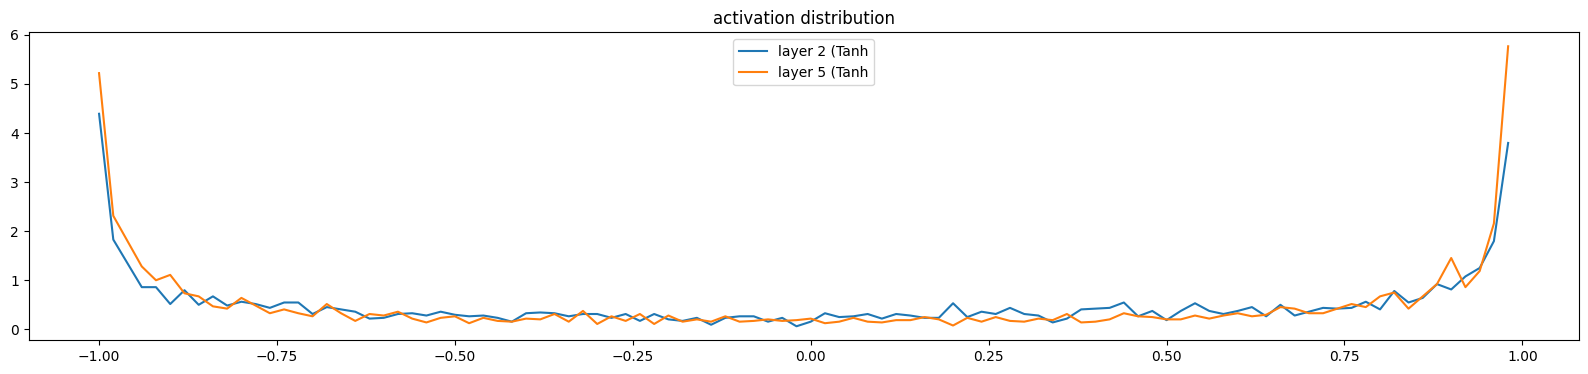

In [16]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean() * 100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution');

layer 2 (      Tanh): mean +0.000000, std 5.263274e-03
layer 5 (      Tanh): mean -0.000000, std 4.653299e-03


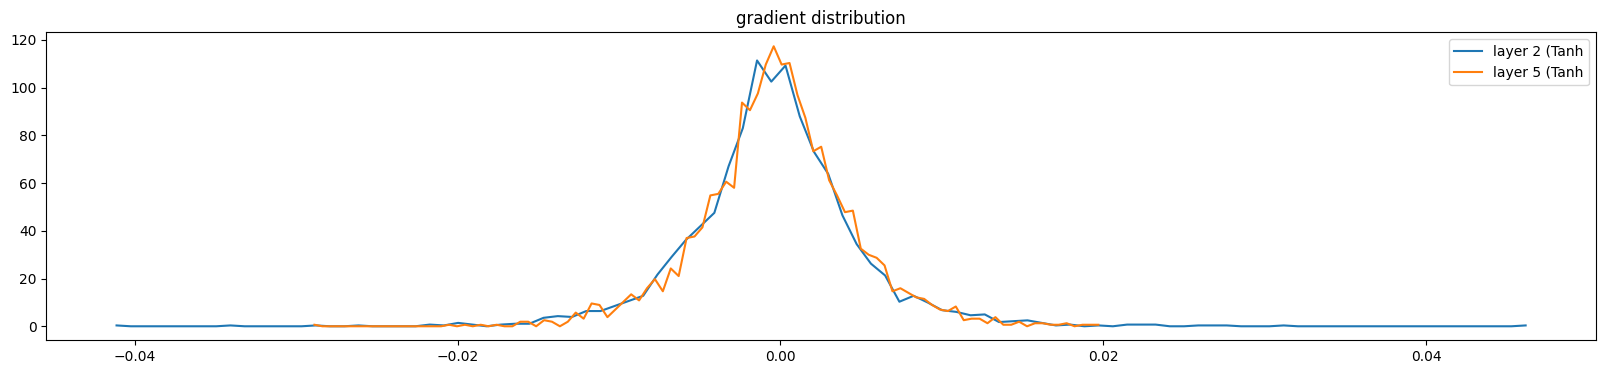

In [17]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution');

weight   (27, 10) | mean -0.000000 | std 1.594954e-02 | grad:data ratio 1.455719e-02
weight  (30, 100) | mean +0.000184 | std 1.027305e-02 | grad:data ratio 2.333387e-02
weight (100, 100) | mean +0.000031 | std 7.486648e-03 | grad:data ratio 2.742635e-02
weight  (100, 27) | mean -0.000135 | std 9.531577e-03 | grad:data ratio 2.531971e-02


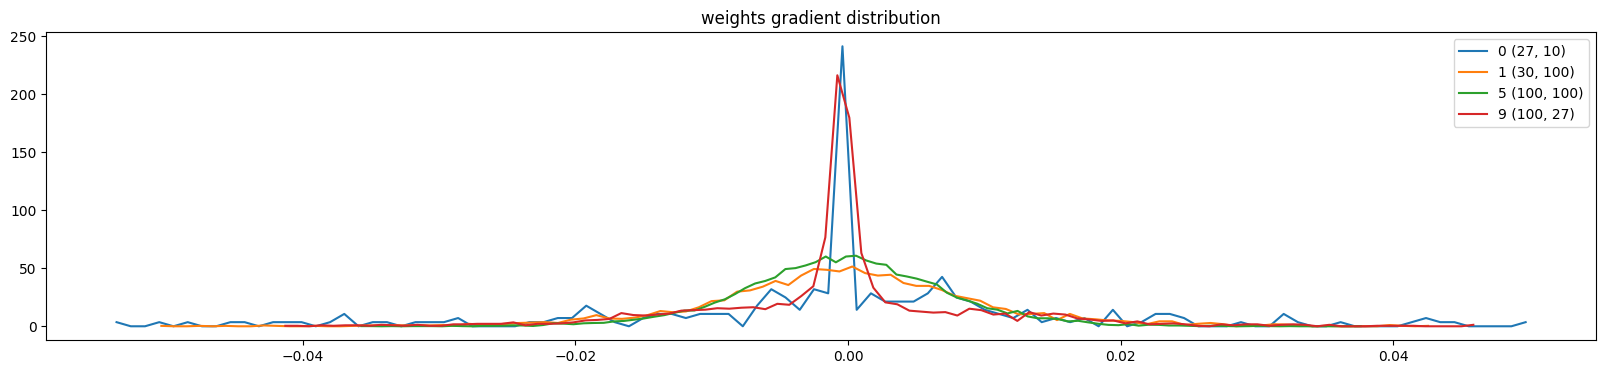

In [18]:
plt.figure(figsize=(20,4))
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

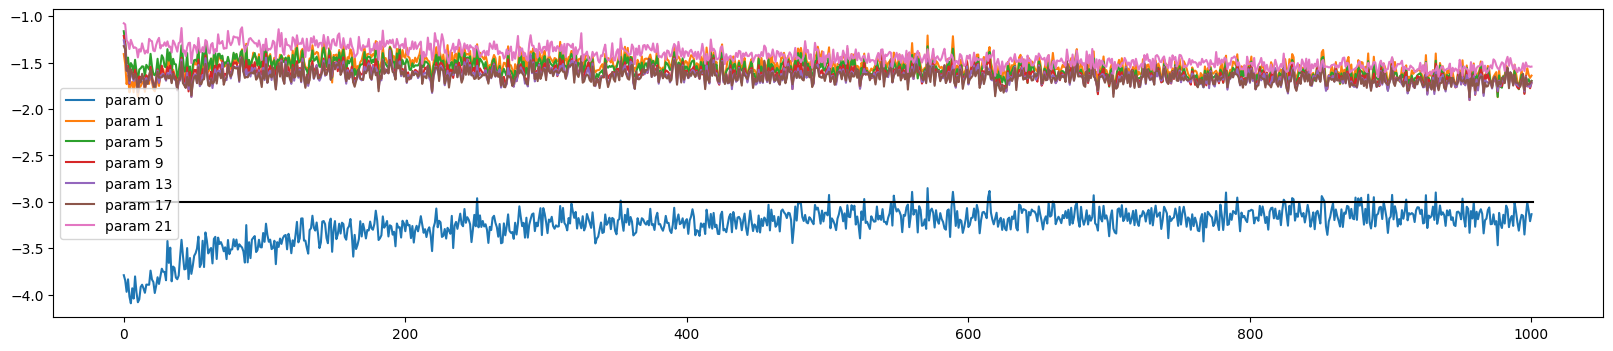

In [ ]:
plt.figure(figsize=(20,4))
legends=[]
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k')
plt.legend(legends)

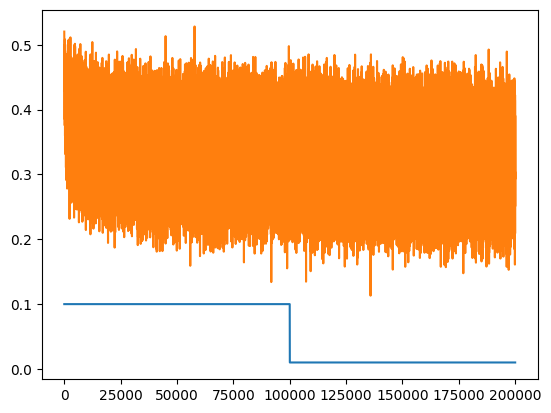

In [19]:
plt.plot(lri)
plt.plot(lossi)

In [20]:
@torch.no_grad()
def split_loss(split):
  x,y = {
      'train': (Xtr, Ytr),
      'val': (Xdev, Ydev),
      'test': (Xte, Yte)
  }[split]

  emb = C[x] # embed the characters into the vectors
  print(emb.shape)
  x = emb.view(-1, INPUT_NEURON_COUNT) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')


torch.Size([182625, 3, 10])
train 2.064594030380249
torch.Size([22655, 3, 10])
val 2.1139442920684814


In [21]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)
for layer in layers:
  layer.training = False

for _ in range(20):

    out = []
    context = [0] * BLOCK_SIZE # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      x = emb.view(1, -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x

      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

montaymyah.
seel.
ndhayla.
remmadiendra.
grace.
kaiel.
izely.
jenne.
elisson.
arleigh.
malaia.
nosalbergiaghie.
trick.
weller.
novulyn.
brence.
ryyah.
faeh.
yuma.
myston.


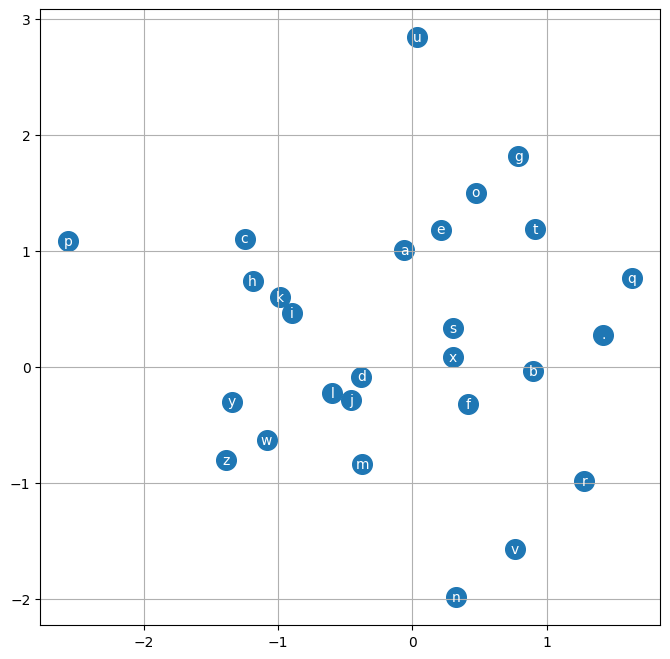

In [22]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')